# Syntax Repair with Language Models

## Dataset

TODO: Detail data, deepfix cite, explain 
types of errors

#

In [1]:
import pickle
with open("data/syntax-benchmark.pkl", "rb") as fin:
    benchmark = pickle.load(fin)

In [3]:
# number of buggy programs
len(benchmark)

6978

In [4]:
from repair import utils
import tqdm
# distribution of length in terms of tokens
num_tokens = [len(utils.tokenize(b.code)) for b in tqdm.tqdm(benchmark)]


100%|██████████| 6978/6978 [00:12<00:00, 564.21it/s]


Text(0, 0.5, 'Count of cases')

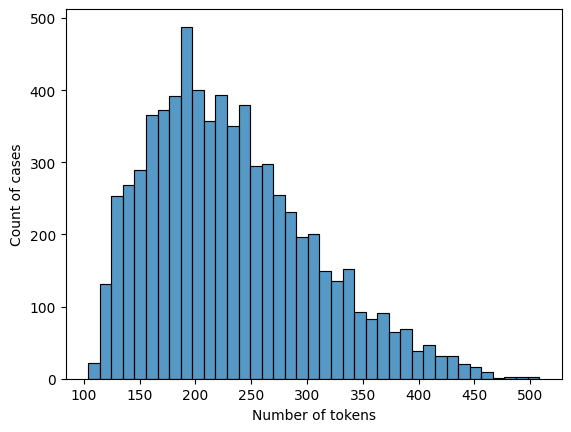

In [5]:
import seaborn as sns
ax = sns.histplot(num_tokens)
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Count of cases")

Text(0, 0.5, 'Count of cases')

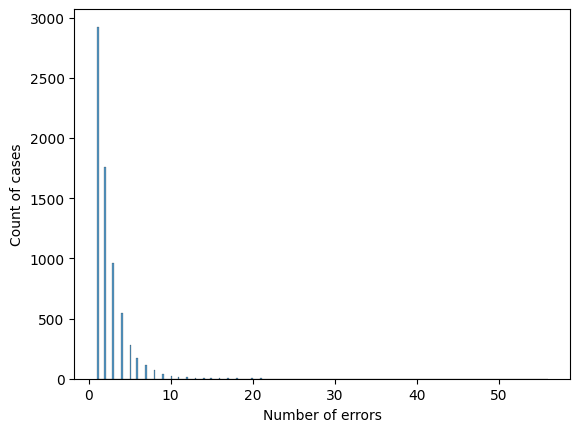

In [6]:
# distribution of number of compile errors
errorcounts = [b.errorcount for b in benchmark]
ax = sns.histplot(errorcounts)
ax.set_xlabel("Number of errors")
ax.set_ylabel("Count of cases")

Text(0, 0.5, 'Number of compilation errors')

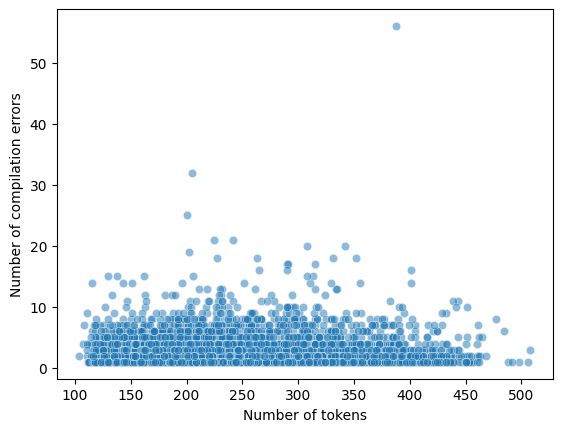

In [7]:
# Relationship between length and errors
ax = sns.scatterplot(x=num_tokens, y=errorcounts, alpha=0.5)
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Number of compilation errors")

In [8]:
# random sample of k compile errors
import random
random.seed(42)
random.shuffle(benchmark)
k = 10
sampled = benchmark[:k]
for i, case in enumerate(sampled):
    print("Sample", i)
    print(case.code)
    print("Error:", case.error)
    print("--------------")

Sample 0
#include <stdio.h>
int main(){
    int n,k,i,j,a,b;
    
    scanf("%d",&n);
     int a[n];
    
    scanf("%d",&k);
    
    for(i=0;i<n;i++)
    {
        a[i]=i+1;
    }
    for(i=0;i<n;i++)
    {
        k-a[i]=b;
        for(j=0;j<n;j++)
        {
            if(b=a[j])
            break;
        }
    }
    if(j!=n-1)
    printf("lucky")
    else
    printf("unlucky");
    
    return 0;
}
Error: In function ‘main’:
6:10: error: conflicting types for ‘a’
      int a[n];
          ^
3:17: note: previous declaration of ‘a’ was here
     int n,k,i,j,a,b;
                 ^
16:15: error: lvalue required as left operand of assignment
         k-a[i]=b;
               ^
25:5: error: expected ‘;’ before ‘else’
     else
     ^
--------------
Sample 1
#include <stdio.h>
#include <stdlib.h>
int catal(int n)
{
    if (n==0)
    return 1;
    else return (2*(2*n-1))/(n+1);
}
int main() {
int a,i,n,j,str[17],t;
for (i=0;i<17;i++)
{str[i]=catal(i);
}
scanf("%d",&t);
for (j=0;j<t;j++)

# Metrics

In [9]:
bad_simple = "int main( {return 0;}"
ok_simple = "int main() {return 0;}"

In [10]:
utils.gcc_compile(bad_simple)

CompileResult(ok=False, error='/tmp/tmpmo3b2rsh.c:1:11: error: expected declaration specifiers or ‘...’ before ‘{’ token\n    1 | int main( {return 0;}\n      |           ^\n', errorcount=1)

In [11]:
utils.gcc_compile(ok_simple)

CompileResult(ok=True, error=None, errorcount=0)

In [12]:
# typically: satisfy oracle (i.e. compiler) but also need to limit edit distance (e.g. deleting everything yields compilable unit)
# token edit distance: standard levenshtein distance but on lexer outputs (better than simple string distance)
utils.token_edit_distance(
    bad_simple,
    ok_simple
)

1.0

In [13]:
from importlib import reload
utils = reload(utils)
# can also use tree edit distance with parse tree that maintains syntax errors
utils.tree_edit_distance(
    bad_simple,
    ok_simple
)

1.0

# Running our benchmark suite

TODO

# Fixing Syntax Errors with Codex

In [14]:
# Reference and explain https://arxiv.org/abs/2208.11640

In [15]:
from repair.engines import codex

In [16]:
import inspect
print(inspect.getsource(codex.CodexEngine))

class CodexEngine(object):

    def __init__(
        self,
        openai_key: str,
        temperature: float = 0,
        n: int = 1,
        maxtokens: int = 200,
        stop: str = "///",
        engine: str = "code-davinci-002",
    ):
        openai.api_key = openai_key
        self.temperature = temperature
        self.maxtokens = maxtokens
        self.n = n
        self.top_p = 1.0
        self.presence_penalty = 0.0
        self.frequency_penalty = 0.0
        self.stop = stop
        self.engine = engine

    def complete(self, prompt: str, **kwargs):
        try:
            response = openai.Completion.create(
                engine=self.engine,
                prompt=prompt,
                max_tokens=kwargs.get("maxtokens", self.maxtokens),
                temperature=kwargs.get("temperature", self.temperature),
                top_p=kwargs.get("top_p", self.top_p),
                presence_penalty=kwargs.get("presence_penalty",
                                       

In [17]:
import inspect
print(inspect.getsource(codex.CodexBaseRepair))

class CodexBaseRepair(object):
    """
    Based on https://beta.openai.com/examples/default-fix-python-bugs
    """

    def __init__(self, *args, **kwargs):
        self.codex = CodexEngine(*args, **kwargs)

    def get_prompt(self, code: str, **kwargs) -> str:
        # Based on https://beta.openai.com/examples/default-fix-python-bugs
        prompt = """//// Fix bugs in the below code\n"""
        prompt += f"/// Buggy C\n{code}\n\n"
        prompt += "/// Fixed C"
        if 'fixed' in kwargs and kwargs['fixed'] is not None:
            prompt += f"\n{kwargs['fixed']}\n\n"

        return prompt

    def get_repair_from_completion_(
            self, completion_dict: Dict[str, Any]) -> Dict[str, Any]:
        comp = completion_dict["completion"]
        # remove first \n and last \n, result from our prompt style
        if comp[0] == "\n":
            comp = comp[1:]
        if comp[-1] == "\n":
            comp = comp[:-1]
        return {"repair": comp, "score": completion_dict[

In [21]:
from importlib import reload
import openai
import os
openai.api_key = os.getenv("OPENAI_API_KEY")
codex = reload(codex)
codex_base = codex.CodexBaseRepair(openai.api_key)

In [22]:
codex_base.repair("int main({return 0;}")

[{'repair': 'int main() {return 0;}\n', 'score': -0.2851033773461538}]

In [23]:
from importlib import reload
codex = reload(codex)
codex_base = codex.CodexBaseRepair(openai.api_key)

In [24]:
codex_base.repair(bad_simple, maxtokens=10)

[{'repair': 'int main() {return 0;}', 'score': -0.15866394315}]

### Add error message to improve error localization

In [25]:
print(inspect.getsource(codex.CodexWithErrorInfo))

class CodexWithErrorInfo(CodexBaseRepair):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.error_cache = {}

    def _get_error_info(self, code: str) -> str:
        if code not in self.error_cache:
            self.error_cache = gcc_compile(code).error
        return self.error_cache[code]

    def get_prompt(self, code: str, **kwargs):
        prompt = """//// Fix bugs in the below code\n"""
        prompt += f"/// Buggy C\n{code}\n\n"
        error_msg = self._get_error_info(code)
        prompt += f"/// Error Message\n{error_msg}\n\n"
        prompt += "/// Fixed C"
        if 'fixed' in kwargs and kwargs['fixed'] is not None:
            prompt += f"\n{kwargs['fixed']}\n\n"

        return prompt



In [26]:
benchmark[0]

DeepFixRecord(code_id='prog30938', user_id='user400', problem_id='prob90', code='#include <stdio.h>\nint main(){\n    int n,k,i,j,a,b;\n    \n    scanf("%d",&n);\n     int a[n];\n    \n    scanf("%d",&k);\n    \n    for(i=0;i<n;i++)\n    {\n        a[i]=i+1;\n    }\n    for(i=0;i<n;i++)\n    {\n        k-a[i]=b;\n        for(j=0;j<n;j++)\n        {\n            if(b=a[j])\n            break;\n        }\n    }\n    if(j!=n-1)\n    printf("lucky")\n    else\n    printf("unlucky");\n    \n    return 0;\n}', error='In function ‘main’:\n6:10: error: conflicting types for ‘a’\n      int a[n];\n          ^\n3:17: note: previous declaration of ‘a’ was here\n     int n,k,i,j,a,b;\n                 ^\n16:15: error: lvalue required as left operand of assignment\n         k-a[i]=b;\n               ^\n25:5: error: expected ‘;’ before ‘else’\n     else\n     ^', errorcount=3)

In [29]:
codex = reload(codex)
codex_msg = codex.CodexWithErrorInfo(openai.api_key)

In [30]:
print(codex_msg.get_prompt(bad_simple))

//// Fix bugs in the below code
/// Buggy C
int main( {return 0;}

/// Error Message
/tmp/tmpqxvuqviw.c:1:11: error: expected declaration specifiers or ‘...’ before ‘{’ token
    1 | int main( {return 0;}
      |           ^


/// Fixed C


In [31]:
codex_msg.repair(bad_simple, maxtokens=100, n=5)

[{'repair': 'int main() {return 0;}\n', 'score': -0.29703754399999993}]

### Add few-shots to help show what kind of edits may be needed

In [32]:
codex = reload(codex)
print(inspect.getsource(codex.CodexWithFewShots))

class CodexWithFewShots(CodexBaseRepair):
    """
    Based on https://beta.openai.com/examples/default-fix-python-bugs
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prompt_helper = CodexWithErrorInfo(*args, **kwargs)

    def get_prompt(self, code: str, **kwargs):
        few_shots = kwargs.get('fewshots', None) or []
        prompt = ""
        for (buggy_shot, fixed_shot) in few_shots:
            prompt += self.prompt_helper.get_prompt(buggy_shot,
                                                    fixed=fixed_shot)

        prompt += self.prompt_helper.get_prompt(code)
        return prompt



In [33]:
codex_shots = codex.CodexWithFewShots(openai.api_key)

In [34]:
print(codex_shots.repair(bad_simple, fewshots=[('void main(a{}', 'void main(a){}')], n=10))

[{'repair': 'int main() {return 0;}\n', 'score': -0.10202952868000001}]


### How to create an initial example bank?

In [37]:
# bootstap it yourself
codex = reload(codex)
example_bank = codex.generate_basic_example_bank(benchmark, size=100)

### Picking Few-shots

* Fixed (cover some basic examples by hand)
* Random (sample from other programs you have)
* Similar (what does it mean to be similar?)